# Exploratory Data Analysis

## Libraries and data import

In [1]:
import os, sys

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import plotly.express as px
import plotly.io as pio
pio.templates.default = 'seaborn'

sys.path.append(os.path.abspath('..'))

In [2]:
plt.style.use('../assets/graphmel.mplstyle')

In [3]:
from src.utils import FILES, extract_study_phase, CONNECTION_DIR, DATA_FOLDERS

## Lesions

### Dataset information

The lesions dataset contains the following features:

* Each patient is attributed to a unique `gpcr_id [int]` 
* Each study is identified relative to the start of treatment with `study_name [str]` and the processed `study_phase [int]`
* `roi_id [int]` is an identifier for the lesion's ROI (Region Of Interest)
* `roi_name [str]` is a textual identifier for the lesion
* `lesion_label_id [int]` is an identifier for the lesion's label
* `pars_bodypart_petct [str]`, `pars_region_petct [str]`, `pars_subregion_petct [str]`, `pars_laterality_petct [str]` are categorical values output by PARS that help identify the location of the lesion
* `pars_classification_petct [str]` is a categorical variable (either `benign` or `suspicious`)
* `vol_ccm [float]` is the lesion volume in cubic centimeters
* `max_suv_val [float]`, `mean_suv_val [float]`, `min_suv_val [float]`, and `sd_suv_val [float]` are relative to the lesions [SUV  (Standardized Uptake Values)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3026294/)
* `is_malignant [bool]` is the boolean value of `pars_classification_petct == 'suspicious'`
*  `assigned_organ [str]` is the lesion's assigned organ (which is PARS output)

### Preprocessing

In [4]:
lesions = pd.read_csv(os.path.join(CONNECTION_DIR, DATA_FOLDERS[2], FILES[DATA_FOLDERS[2]]['lesions']))
lesions['study_phase'] = lesions.study_name.apply(extract_study_phase)
lesions = lesions[lesions.pars_classification_petct != 'benign']

# Sorting by PARS classification allows for visualization consistency
lesions.sort_values(by='pars_classification_petct', inplace=True)
n_lesions, f_lesions = lesions.shape

print(f'Imported {n_lesions} lesions with {f_lesions} features. Null values: {lesions.isna().sum().sum()}')

Imported 3503 lesions with 18 features. Null values: 0


In [ ]:
lesions

In [ ]:
lesions_labels = {
    'vol_ccm': 'Lesion volume (ccm)',
    'pars_classification_petct': 'PARS lesion classification',
    'study_phase': 'Study phase (relative to treatment start)',
    'assigned_organ': 'Assigned organ'
}

In [ ]:
top_h_legend = dict(orientation='h', yanchor="bottom", y=1.02)

### Visualisations

In [ ]:
descending_organs = list(lesions.groupby('assigned_organ').size().sort_values(ascending=False).index)

px.histogram(lesions, x='assigned_organ', color='pars_classification_petct', 
             category_orders={'assigned_organ': descending_organs},
             labels=lesions_labels) \
    .update_layout(legend=top_h_legend, yaxis_title='Lesions')

In [ ]:
progression = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[1], FILES['progression']))
progression['study_phase'] = progression.study_name.apply(extract_study_phase)

In [ ]:
avg_lesion_vol_w_na = lesions.groupby(['gpcr_id', 'study_phase']) \
    .vol_ccm.mean().to_frame('vol_ccm').reset_index() \
    .merge(progression[['gpcr_id', 'prediction_score', 'study_phase']],
           on=['gpcr_id', 'study_phase'], how='inner')
    
avg_lesion_vol = avg_lesion_vol_w_na.dropna()

print(f'All studies with progression: {progression.shape[0]} \n'
      f'Aggregated lesions per study from lesions df: {avg_lesion_vol_w_na.shape[0]} \n'
      f'Inner merge with dropped NA progression values: {avg_lesion_vol.shape[0]}')

px.box(avg_lesion_vol, x='study_phase', y='vol_ccm', color='prediction_score', 
       labels={**lesions_labels,
               'vol_ccm': 'Average lesion volume (ccm)',
               'prediction_score': 'Response'}) \
    .update_layout(legend=top_h_legend)

In [ ]:
location_hierarchy = ['pars_bodypart_petct', 'pars_region_petct', 'pars_subregion_petct']
locations = lesions.groupby(location_hierarchy).size().to_frame('lesions').reset_index()

px.sunburst(locations, path=location_hierarchy, values='lesions') \
    .update_layout(title='Sunburst chart of lesion location')

## Studies

### Dataset information

* Each patient is attributed to a unique `gpcr_id [int]` 
* Each study is identified relative to the start of treatment with `study_name [str]` and the processed `study_phase [int]`
* `is_before_treatment [bool]`, `is_during_treatment [bool]`, and `is_after_treatment_end [bool]` are boolean values that explain when the study occured relative to treatment start and end
* `nth_before_treatment [float]`, `nth_after_treatment_start [float]`, `nth_during_treatment [float]`, and `nth_after_treatment_end [float]` is the scan number relative to treatment start and end
* `n_days_to_treatment_start [int]` and `n_days_to_treatment_end [int]` are the number of days to treatment start and end
* `is_malignant [int]` is the aggregate number of malignant lesions in the exam, which is renamed to `malignant_lesions [int]` during preprocessing
* Boolean values about segmentation existance are contained in `brain_seg_exists [bool]`, `bones_seg_exists [bool]`, `spleen_seg_exists [bool]`, `aorta_seg_exists [bool]`, `heart_seg_exists [bool]`, `kidney_right_seg_exists [bool]`, `kidney_left_seg_exists [bool]`, `lung_right_seg_exists [bool]`, `lung_left_seg_exists [bool]`, and `liver_seg_exists [bool]`

### Preprocessing

In [10]:
studies = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[0], FILES[DATA_FOLDERS[0]]['studies']))
studies.rename(columns={'is_malignant': 'malignant_lesions'}, inplace=True)
# studies = studies.merge(progression, on=['gpcr_id', 'study_name'], how='inner')

n_studies, f_studies = studies.shape

print(f'Imported {n_studies} studies with {f_studies} features. Null values: {studies.isna().sum().sum()}')

Imported 472 studies with 22 features. Null values: 1043


In [12]:
studies[['gpcr_id', 'study_name', 'n_days_to_treatment_start']]

,gpcr_id,study_name,n_days_to_treatment_start
0,34610001,pre-02,-43
1,34610001,pre-01,-7
2,34610001,post-01,87
3,34610001,post-02,183
4,34610001,post-03,275
...,...,...,...
467,34610149,post-02,136
468,34610150,post-01,63
469,34610150,post-02,147
470,34610150,post-03,247


In [21]:
meta_studies = []

for patient in studies.gpcr_id.unique():

    d = studies[studies.gpcr_id == patient].n_days_to_treatment_start.to_numpy()

    time = np.abs(d[:-1] - d[1:])
    
    meta_studies.append(dict(
        gpcr_id=patient,
        no_studies=len(d),
        avg_time_between_studies=time.mean()
    ))

In [24]:
meta_studies = pd.DataFrame(meta_studies)

In [27]:
meta_studies.avg_time_between_studies.mean()

102.62488103796514

<AxesSubplot:ylabel='Frequency'>

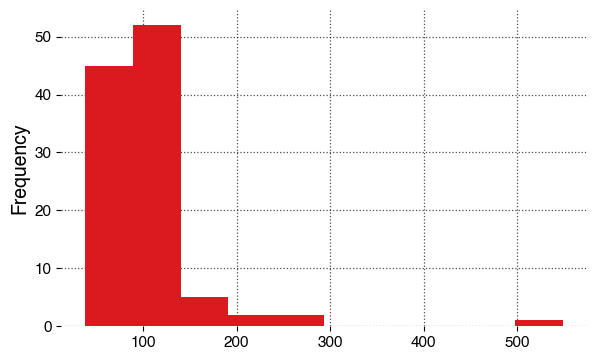

In [26]:
meta_studies.avg_time_between_studies.plot(kind='hist')

In [ ]:
studies

In [ ]:
studies_labels = {
    **lesions_labels,
    'prediction_score': 'Immunotherapeutic response',
    'response': 'TMTV response',
    'tmtv': 'Total Metabolic Tumor Volume (ccm)',
    'baseline': 'Baseline TMTV (ccm)'
}

#### Creating temporary labels using TMTV (Total Metabolic Tumor Volume)


* If TMTV is non-zero, but lower compared to baseline: Partial response
* If TMTV is zero / no lesions detected: Complete response
* If TMTV > 'best' previous response: progressive disease.
     'Best' previous responds means minimum TMTV in previous time points
* Otherwise: stable disease

In [ ]:
def classify_response(row):
    # Compare current vs. baseline
    if row.tmtv < row.baseline:
        return 'NPD'
    elif row.tmtv == row.baseline:
        return np.nan
    else:
        return 'PD'

In [ ]:
# Compute TMTV by summing `vol_ccm` per study
labels = lesions.groupby(['gpcr_id', 'study_phase']).vol_ccm.sum().to_frame('tmtv').reset_index()

# Find `labels` id of each patient's baseline TMTV
baseline_idx = labels.groupby('gpcr_id').study_phase.idxmin().to_dict()
labels['baseline'] = labels.gpcr_id.apply(
    lambda i: labels.loc[baseline_idx[i]].tmtv)
labels['response'] = labels.apply(classify_response, axis=1)

print(f'Response computed for {labels.shape[0]} studies: \n{labels.response.value_counts()}')

In [ ]:
labels = labels.merge(progression[['gpcr_id', 'study_phase', 'prediction_score', 'pseudorecist']],
             on=['gpcr_id', 'study_phase'], how='inner')

In [ ]:
fig, ax = plt.subplots(1, 2)

cm = confusion_matrix(progression[['prediction_score', 'pseudorecist']].dropna().prediction_score, 
                      progression[['prediction_score', 'pseudorecist']].dropna().pseudorecist,
                      labels=['PD', 'NPD'])

CM = ConfusionMatrixDisplay(cm, display_labels=['PD', 'NPD']).plot(ax=ax[0])

ax[0].set_xlabel('Pseudorecist'), ax[0].set_ylabel('Prediction score')


cm = confusion_matrix(labels[['prediction_score', 'response']].dropna().prediction_score, 
                      labels[['prediction_score', 'response']].dropna().response,
                      labels=['PD', 'NPD'])

CM = ConfusionMatrixDisplay(cm, display_labels=['PD', 'NPD']).plot(ax=ax[1])

ax[1].set_xlabel('TMTV Response'), ax[1].set_ylabel('Prediction score')

plt.gcf().set_size_inches(15, 6)
plt.show()

### Visualisations

In [ ]:
labels

In [ ]:
px.scatter(labels[labels['prediction_score'].notna()], x='study_phase', y='tmtv', color='prediction_score',
           labels=studies_labels) \
    .update_layout(legend=top_h_legend)

In [ ]:
# Checking post-1 label imbalance
post_1_response = labels[labels.study_phase == 1].prediction_score.value_counts()

print(f'Response imbalance for post-1 studies: \n{post_1_response}')

In [ ]:
px.histogram(labels[(labels.study_phase == 1) & (labels['prediction_score'].notna())], 
             x='tmtv', color='prediction_score',
             nbins= 40, marginal="rug",
             labels=studies_labels) \
    .update_layout(legend={**top_h_legend, 'y': 1.0},
                   yaxis_title='Studies (count)',
                   title='Post-1 study phase response distribution') \
    .update_traces(opacity=0.7)

## Patients

### Dataset information

### Preprocessing

In [ ]:
patients = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[0], FILES['patients']))

patients['age_at_treatment_start_in_years'] = \
    patients.age_at_treatment_start_in_years.apply(
        lambda a: 90 if a == '90 or older' else int(a))

patients['survival_1_year'] = (patients.survival_in_days > 365)

blood = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[1], FILES['blood']))
blood.drop(columns=['n_days_to_treatment_start', 'n_days_to_treatment_end'], inplace=True)
blood.rename(columns={feature: feature.replace('-', '_') for feature in blood.columns}, inplace=True)

patients = patients.merge(blood, on='gpcr_id', how='inner')

n_patients, f_patients = patients.shape

print(f'Imported {n_patients} patients with {f_studies} features. Null values: {patients.isna().sum().sum()}')

In [ ]:
patients

In [ ]:
patients_labels = {
    **studies_labels,
    'age_at_treatment_start_in_years': 'Age (treatment start, years)',
    'duration_treatment_in_days': 'Treatment duration (days)',
    'death_event_observed': 'Death observed',
    'survival_in_days': 'Survival time (days)',
    'time': 'Time (days)',
    'survival_probability': 'Survival probability',
    'survival_1_year': '1-year Survival',
    'bmi': 'Body-Mass Index',
    'sex': 'Sex'
}

### Visualisations

In [ ]:
px.histogram(patients, x='age_at_treatment_start_in_years', color='survival_1_year',
             labels=patients_labels) \
    .update_layout(legend=top_h_legend, yaxis_title='Patients (count)', barmode='overlay') \
    .update_traces(opacity=0.5)

In [ ]:
px.histogram(patients, x='duration_treatment_in_days', facet_col='survival_1_year',
             labels=patients_labels) \
    .update_layout(legend=top_h_legend, yaxis_title='Patients (count)')

In [ ]:
px.scatter(patients, x='age_at_treatment_start_in_years', 
           y='survival_in_days', color='survival_1_year',
           labels=patients_labels) \
    .update_layout(legend=top_h_legend)

In [ ]:
!pip install -q scikit-survival
from sksurv.nonparametric import kaplan_meier_estimator

# Kaplan-Meier
time, s_prob = kaplan_meier_estimator(patients.death_event_observed, patients.survival_in_days)
km_df = pd.DataFrame(np.array([time, s_prob]).T, columns=['time', 'survival_probability'])

In [ ]:
px.line(km_df, x='time', y='survival_probability', line_shape='hv',
        labels=patients_labels)

In [ ]:
px.scatter(patients, x='bmi', y='age_at_treatment_start_in_years', color='sex',
           labels=patients_labels) \
    .update_layout(legend=top_h_legend)

In [ ]:
px.scatter_matrix(patients, 
                  dimensions=['asat_sang_ul', 'bili_totale_sang_umoll', 'mono_absolus_gl',
       'alat_sang_ul', 'plaquettes_sang_gl', 'lympho_absolus_gl',
       'albumine_sang_gl', 'proteine_c_reacsang_mgl', 'potassium_sang_mmoll',
       'hemoglobine_sang_gl']) \
    .update_layout(legend=top_h_legend)

In [ ]:
px.scatter_matrix(patients, 
                  dimensions=['calcium_sang_mmoll', 'ldh_sang_ul',
       'creatinine_sang_umoll', 'pal_sang_ul', 'neutro_absolus_gl',
       'eosini_absolus_gl', 'baso_absolus_gl', 'ggt_sang_ul',
       'gfr_cal_mlmin173m2', 'leucocytes_sang_gl']) \
    .update_layout(legend=top_h_legend)

In [ ]:
px.scatter_matrix(patients, 
                  dimensions=['eGFRCKD2', 'eGFRCG', 'X67',
       'NRAS_MUTATION', 'NRAS_MUT_TYPE', 'BRAF_MUTATION', 'BRAF_MUT_TYPE',
       'concomittant_tvec', 'concomittant_LAG3', 'prior_targeted_therapy',
       'prior_treatment', 'immuno_therapy_type', 'nivo_maintenance']) \
    .update_layout(legend=top_h_legend)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7360151b-146e-499a-b01b-835ca18c34fa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>